# Inaugural Project

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize 
from matplotlib import pyplot as plt 
plt.style.use("seaborn") 
%matplotlib inline

import matplotlib.pyplot as plt # baseline module
from mpl_toolkits.mplot3d import Axes3D # for 3d figures
plt.style.use('seaborn-whitegrid') 

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import ippy



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

We construct a function that takes (x,y,p) as arguments and returns the agents' optimal insurance coverage.

In [3]:
# utility function 

"""defining parameters"""

mp ={'y':1,'p':0.2,'theta':-2} # just add parameters to this dictionary

"""defining functions"""

def premium(q,mp):
    return mp['p']*q

def utility(z,mp):
  
    return (z**(1+mp['theta']))/(1+mp['theta'])


def expected_utility(x, q, mp):

    z_1 = mp['y'] - x + q - premium(q,mp)
    z_2 = mp['y'] - premium(q,mp)

    return mp['p']*utility(z_1,mp)+(1-mp['p'])*utility(z_2,mp)


In [15]:
"""i. constructing a function, that finds the optimal q for given levels of x,y,p"""

x_guess=0.4 #an initial guess
N=10
q_optimal=np.linspace(0.0,x_guess,N)
u_vector = np.empty(N)

u_best = -np.inf # initial maximum
q_best = np.nan # not-a-number

for i,q in enumerate(q_optimal):
    u_now = u_vector[i] = expected_utility(x_guess, q, mp)
    if u_now>u_best:
        q_best=q
        u_best=expected_utility(x_guess, q, mp)
        
print(f'Optimal level with loop is {u_best:.3f} at q = {q_best:.3f}')


Optimal level with loop is -1.087 at q = 0.400


In [16]:
"""ii.+iii. - making a grid and optimizing for different levels of x""" 
N=10 #number of elements
x=np.linspace(0.01,0.9,N) # an array of N number of x's equally distributed in the range

for i in x:
    initial_guess = [i/2]
    obj = lambda q: -expected_utility(i, q, ippy.mp)
    res=optimize.minimize_scalar(obj, initial_guess, method="bounded",bounds=(1e-5,i))
    q_star=res.x 
 
    print(f"For x = {i:.3f} the optimal q is {q_star:.3f}")

For x = 0.010 the optimal q is 0.010
For x = 0.109 the optimal q is 0.109
For x = 0.208 the optimal q is 0.208
For x = 0.307 the optimal q is 0.307
For x = 0.406 the optimal q is 0.406
For x = 0.504 the optimal q is 0.504
For x = 0.603 the optimal q is 0.603
For x = 0.702 the optimal q is 0.702
For x = 0.801 the optimal q is 0.801
For x = 0.900 the optimal q is 0.900


Text(0.5, 1.0, 'Optimal coverage amount q as a function of monetary loss x')

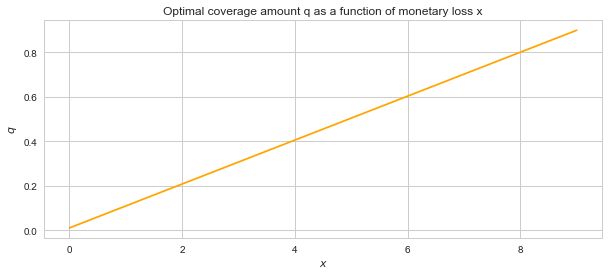

In [17]:
"""Plotting the x's and the q_star's"""
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)

ax.plot(x, color='orange')
ax.grid(True)

# b. add labels
ax.set_xlabel('$x$')
ax.set_ylabel('$q$')
ax.set_title('Optimal coverage amount q as a function of monetary loss x')


As seen from the graph, the general solution according to Mossin’s model on insurance policies suggests that from the agents’ point of view, for each value of monetary losses x, the optimal coverage q must be equal to the losses.

# Question 2

Now we want to find the set of acceptable contracts from the agents’ point of view, which entail all the contracts (q, π) that ensure an expected value at least good as not having an insurance V(q;π) = V_0.

In [18]:
mp['x']=0.6 #adding value of x to the dictionary with all the model parameters
print(mp) #checking to see that it is added

"""checking what the expected value for the uninsured is"""

def expected_utility_uninsured(mp):
    return mp['p']*utility(mp['y'] - mp['x'],mp)+(1-mp['p'])*utility(mp['y'],mp)

print("expected value for the uninsured is:")
print(expected_utility_uninsured(mp))

{'y': 1, 'p': 0.2, 'theta': -2, 'x': 0.6, 'gamma': 0.95}
expected value for the uninsured is:
-1.3


In [19]:
def expected_utility_insured(q, mp, pi): #defining the utility function where pi is a variabel and not a function

    z_1 = mp['y'] - mp['x'] + q - pi
    z_2 = mp['y'] - pi

    return mp['p']*utility(z_1,mp)+(1-mp['p'])*utility(z_2,mp)

"""solving for pi at given level of q"""
def optimal(pi):
    return np.absolute(expected_utility_insured(q=0.02, mp=mp, pi=pi)-expected_utility_uninsured(mp))

sol = optimize.minimize_scalar(optimal, method='bounded', bounds=(0,0.6)) #we only look at the interval [0,0.6] 
pi = sol.x

print(pi)

0.012043720247529826


In [12]:
"""Constructing grid"""

N=10 #number of elements
q_vector=np.linspace(0.01,0.6,N) # an array of N number of x's equally distributed in the range
pi_vector = np.empty(N)

def optimal_grid(pi):
    return np.absolute(expected_utility_insured(q, mp, pi)-expected_utility_uninsured(mp))

for i, q in enumerate(q_vector):
    obj = lambda pi:-optimal_grid(pi)
    initial_pi_guess=[0.0]
    res = optimize.root(obj,initial_pi_guess)
    pi_vector[i]=res.x
  
    premium_pi=mp['p']*q_vector

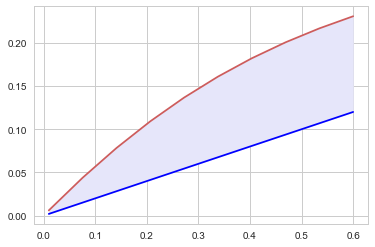

In [11]:
"""figure"""
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(q_vector,premium_pi, color='b')
ax.plot(q_vector,pi_vector, color='indianred')
ax.fill_between(q_vector,pi_vector,premium_pi, color='lavender')


The graph illustrates the acceptable premiums from the agents’ point of view, and the premiums that the insurance company need in order to break even at each value of coverage, q. The coloured parts in the graph thus essentially illustrate the set of feasible premiums from both the agents’ and the insurance company’s point of view for a given q.

# Question 3

Now we consider a modified setup where x is drawn from a beta distribution.

In [13]:
N = 10000
a = 2
b = 7

# drawing from beta distribution
def MC(a,b,N,gamma,pi):
    x = np.random.beta(a,b,size=N)
    z_3=mp['y']-(1-gamma)*x-pi
    return np.mean(utility(z_3,mp))


v1 = MC(a,b,N,gamma = 0.9, pi= 0.2)
v2 = MC(a,b,N,gamma = 0.45, pi= 0.1)

print(v1)
print(v2)



-1.2859713075962251
-1.2994438452707544


In this question, the coverage q is a fraction of x. We know from the first question, that the agent prefers all the potential monetary losses x to be fully covered. From this intuition it follows that the higher the coverage ratio γ, the higher fraction of x the coverage q will be, and thus the higher the coverage will be. From the two insurance policies given, the first one is thus preferred (γ=0.95>γ=0.45).

# Question 4

This time we consider the situation from the insurance company’s point of view and assume, that they know the parameters of the loss distribution.

In [14]:
mp['gamma']=0.95
np.random.seed(500)


def MC_ins(a,b,N,pi,mp):
    x = np.random.beta(a,b,N)
    return np.mean(utility(mp['y']-(1-mp['gamma'])*x-pi,mp))
 
def MC_no(a,b,N,pi,mp):
    x = np.random.beta(a,b,N)
    return np.mean(utility(mp['y']-x,mp))

obj = lambda pi: np.absolute((MC_ins(a,b,N,pi,mp)-MC_no(a,b,N,pi,mp)))
res = optimize.root(obj,0.001,method='broyden1')
pi = res.x
print(f'The premium : {pi:.3f}')


/Users/nadahadraoui/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:910: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)


The premium : 0.241


Given that gamma is 0.95, the profit maximizing premium π* is 0.241

To conclude, we know that the agent will always try to cover the losses that that they incur - the optimal coverage being equal to the losses. The insurance company on the other hand will always try to maximize its profits.